# Multi-Agent Deep AI Finance Researcher from Scratch

Hierarchical multi-agent system with Orchestrator, Researcher, and Editor agents for deep financial research.

## Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from dotenv import load_dotenv
load_dotenv()

from typing import Annotated
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver
from scripts.rag_tools import hybrid_search, live_finance_researcher

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.agents import create_agent
from langchain.messages import HumanMessage, AIMessage, ToolMessage

In [3]:
from langchain_core.tools import tool, InjectedToolCallId
from langgraph.prebuilt import InjectedState
from langgraph.types import Command

from scripts.file_tools import (
    DeepAgentState,
    ls,
    read_file,
    write_file,
    cleanup_files,
    generate_hash,
    _disk_path
)

from scripts.prompts import (
    ORCHESTRATOR_PROMPT,
    RESEARCHER_PROMPT,
    EDITOR_PROMPT,
)

## Initialize Components and Create Worker Agents

In [4]:
# llm = ChatGoogleGenerativeAI(model='gemini-2.5-flash', temperature=0.7)/
llm = ChatGoogleGenerativeAI(model='gemini-3-flash-preview')

conn = sqlite3.connect("data/deep_finance_researcher.db", check_same_thread=False)
checkpointer = SqliteSaver(conn=conn)

In [5]:
# Researcher Agent - uses RAG and live finance tools
researcher_agent = create_agent(
    model=llm,
    tools=[ls, write_file, read_file, hybrid_search, live_finance_researcher],
    system_prompt=RESEARCHER_PROMPT,
    state_schema=DeepAgentState,
)

# Editor Agent
editor_agent = create_agent(
    model=llm,
    tools=[ls, read_file, write_file, cleanup_files],
    system_prompt=EDITOR_PROMPT,
    state_schema=DeepAgentState,
)

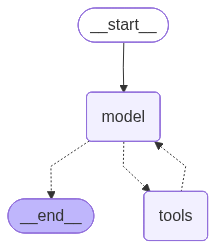

In [6]:
researcher_agent

## Define Orchestrator Tools

In [8]:
@tool
def write_research_plan(
    thematic_questions: list[str],
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
):
    """
    Write the high-level research plan with major thematic questions.

    Args:
        thematic_questions: List of 3-5 major thematic questions
        state: Injected agent state
        tool_call_id: Tool call ID

    Returns:
        Command with ToolMessage confirming the plan was written
    """
    content = "# Research Plan\n\n"

    content = content + "## User Query\n"
    content = content + state["messages"][-1].text + "\n\n"

    content = content + "## Thematic Questions\n\n"
    for i, question in enumerate(thematic_questions, 1):
        content = content + f"{i}. {question}\n"

    path = _disk_path(state, "research_plan.md")
    with open(path, "w", encoding="utf-8") as f:
        f.write(content)

    msg = f"[RESEARCH PLAN WRITTEN] research_plan.md with {len(thematic_questions)} thematic questions"
    return Command(update={"messages": [ToolMessage(msg, tool_call_id=tool_call_id)]})



In [7]:
@tool
def run_researcher(
            theme_id: int,
            thematic_question: str,
            state: Annotated[DeepAgentState, InjectedState],
            max_retries: int = 2
        ):
    """
    Run a single Research agent for ONE thematic question.

    Args:
        theme_id: The theme number (1, 2, 3, etc.)
        thematic_question: The specific thematic question to research
        state: Injected agent state
        max_retries: Number of retry attempts

    Returns:
        Status string for the orchestrator
    """
    
    file_hash = generate_hash(f"{theme_id}_{thematic_question}")

    ai_message_instruction = f"""[THEME {theme_id}] {thematic_question}

                        Save research to: researcher/{file_hash}_theme.md
                        Save sources to: researcher/{file_hash}_sources.txt
                        """

    sub_state: DeepAgentState = {
        "messages": state["messages"] + [AIMessage(ai_message_instruction)],
        "user_id": state.get("user_id"),
        "thread_id": state.get("thread_id"),
    }

    for attempt in range(max_retries + 1):
        try:
            researcher_agent.invoke(sub_state)
            return f"✓ Theme {theme_id} research completed (hash: {file_hash})"
        except Exception:
            print(f"Failed. Trying #{attempt} times")

    return f"✗ Theme {theme_id} failed after {max_retries + 1} attempts"


In [10]:
@tool
def run_editor(state: Annotated[DeepAgentState, InjectedState]) -> str:
    """
    Run the Editor agent to synthesize all research into final report.

    Args:
        state: Injected agent state

    Returns:
        Status string
    """
    sub_state: DeepAgentState = {
        "messages": [HumanMessage(content="Read research_plan.md and all files in the researcher/ folder, then synthesize everything into a comprehensive report.md file.")],
        "user_id": state.get("user_id"),
        "thread_id": state.get("thread_id"),
    }
    editor_agent.invoke(sub_state)
    return "Editor completed. Final report is written to report.md."

## Create Orchestrator Agent

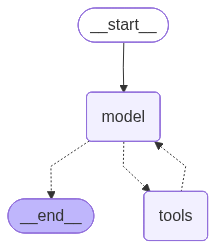

In [11]:
orchestrator_agent = create_agent(
    model=llm,
    tools=[write_research_plan, run_researcher, run_editor, cleanup_files],
    system_prompt=ORCHESTRATOR_PROMPT,
    state_schema=DeepAgentState,
    checkpointer=checkpointer
)

orchestrator_agent

## Examples

In [12]:
from scripts.agent_utils import stream_agent_response

# Simple question - direct answer
stream_agent_response(
    orchestrator_agent,
    "What is a 10-K report?",
    thread_id="thread_002",
    user_id="user_212",
)

A **10-K** is a comprehensive annual report filed by publicly traded companies with the U.S. Securities and Exchange Commission (SEC). 

While a typical "annual report" sent to shareholders is often a colorful marketing document, the 10-K is a formal legal filing that provides a much more detailed picture of a company's financial health and operations.

### Key Sections of a 10-K:
1.  **Business Overview:** A description of the company’s main operations, products, services, and the markets it operates in.
2.  **Risk Factors:** A list of specific risks that could negatively affect the company's business, financial condition, or stock price (e.g., competition, regulatory changes, or supply chain issues).
3.  **Selected Financial Data:** Financial data for the last five years to show the company’s long-term performance.
4.  **Management’s Discussion and Analysis (MD&A):** Management’s perspective on the previous year's results and their goals for the future.
5.  **Financial Statements:** 

In [13]:
# Complex financial research
stream_agent_response(
    orchestrator_agent,
    "Do a detailed analysis of Amazon's financial performance in 2023 and 2024",
    thread_id="thread_003",
    user_id="user_212"
)


  Tool Called: write_research_plan
   Args: {'thematic_questions': ["What were Amazon's key financial metrics (revenue, net income, EPS) in 2023 and the first half of 2024?", "How did Amazon's major business segments (AWS, North America, International) perform in 2023 and early 2024?", 'What were the main drivers of growth and profitability for Amazon during this period (e.g., cost-cutting, advertising, AI)?', 'What are the key risks and challenges Amazon faced or is facing in 2023-2024?', "What is the outlook and analyst sentiment for Amazon's financial performance for the remainder of 2024 and beyond?"]}


  Tool Result (length: 66 chars)


  Tool Called: run_researcher
   Args: {'thematic_question': "What were Amazon's key financial metrics (revenue, net income, EPS) in 2023 and the first half of 2024?", 'theme_id': 1}


  Tool Called: run_researcher
   Args: {'thematic_question': "How did Amazon's major business segments (AWS, North America, International) perform in 2023 and earl

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_paid_tier_input_token_count, limit: 1000000, model: gemini-3-flash
Please retry in 30.374757935s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_paid_tier_input_token_count"
  quota_id: "GenerateContentPaidTierInputTokensPerModelPerMinute"
  quota_dimensions {
    key: "model"
    value: "gemini-3-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  

KeyboardInterrupt: 

In [ ]:
# response = editor_agent.invoke(
#     {'messages':[HumanMessage('write detailed report in report.md')],
#      'user_id':"user_212",
#     'thread_id':"thread_003"
#      }
# )